In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.applications.efficientnet import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import datetime
from PIL import Image

c:\PythonDeepLearning\environments\deep_learning\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
import cv2 
import imghdr
from pathlib import Path

data_dir = 'dataset' 
image_extensions = ['jpeg', 'jpg', 'bmp', 'png', 'gif'] 

bad_files = []

for root, dirs, files in os.walk(data_dir):
    for filename in files:
        file_path = os.path.join(root, filename)
        
        ext = filename.split('.')[-1].lower()
        
        if filename.startswith('.') or ext not in image_extensions:
            print(f"Menghapus file bukan gambar: {file_path}")
            os.remove(file_path)
            continue
            
        try:
            img_type = imghdr.what(file_path)
            if img_type is None:
                print(f"Format tidak dikenali: {file_path}")
                os.remove(file_path)
                bad_files.append(file_path)
                continue
        except Exception:
            print(f"Error membaca header: {file_path}")
            os.remove(file_path)
            continue
            
        try:
            img = cv2.imread(file_path)
            if img is None:
                print(f"Gambar corrupt/rusak: {file_path}")
                os.remove(file_path)
                bad_files.append(file_path)
        except Exception as e:
            print(f"File rusak: {file_path}")
            os.remove(file_path)
            bad_files.append(file_path)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23660\2124627625.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Memulai pemindaian di folder: dataset ...

Selesai! 0 file rusak telah dihapus.
Silakan jalankan ulang kode training/preprocessing Anda.


In [ ]:
# =========================================================
# DATASET SPLITTER (FLAT → train / val / test)
# =========================================================

import os
import shutil
import random

SOURCE_DIR = "dataset"          
TARGET_DIR = "dataset_split"    

TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

random.seed(42)

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(TARGET_DIR, split), exist_ok=True)

for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    images = [
        f for f in os.listdir(class_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    random.shuffle(images)

    n_total = len(images)
    n_train = int(TRAIN_RATIO * n_total)
    n_val   = int(VAL_RATIO * n_total)

    split_map = {
        "train": images[:n_train],
        "val":   images[n_train:n_train + n_val],
        "test":  images[n_train + n_val:]
    }

    for split, files in split_map.items():
        split_class_dir = os.path.join(TARGET_DIR, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for file in files:
            shutil.copy(
                os.path.join(class_path, file),
                os.path.join(split_class_dir, file)
            )

    print(f"✅ {class_name}: {n_train} train | {n_val} val | {n_total - n_train - n_val} test")



✅ Battery: 660 train | 141 val | 143 test
✅ Cardboard: 909 train | 195 val | 196 test
✅ Glass: 909 train | 195 val | 196 test
✅ Metal: 909 train | 195 val | 196 test
✅ Organic: 1117 train | 239 val | 241 test
✅ Paper: 908 train | 194 val | 196 test
✅ Plastic: 907 train | 194 val | 196 test
✅ Textile: 1610 train | 345 val | 345 test
✅ Trash: 872 train | 187 val | 188 test

🎉 Dataset berhasil di-split ke 'dataset_split/'


In [ ]:
# =========================================================
# DATASET PIPELINE FINAL - EFFICIENTNET B0 (BENAR & STABIL)
# =========================================================

import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers

DATASET_DIR = "dataset_split"   
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# -----------------------------
# CLEAN DATASET
# -----------------------------
def clean_images_tf(root_dir):
    removed = 0
    for root, _, files in os.walk(root_dir):
        for file in files:
            path = os.path.join(root, file)

            if not file.lower().endswith((".jpg", ".jpeg", ".png")):
                os.remove(path)
                removed += 1
                continue

            try:
                img = tf.io.read_file(path)
                _ = tf.image.decode_image(img, channels=3)
            except:
                print("REMOVED (TF):", path)
                os.remove(path)
                removed += 1


clean_images_tf("dataset_split")

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

train_ds = train_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

val_ds = val_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

test_ds = test_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


for images, labels in train_ds.take(1):
    print("Image batch:", images.shape)
    print("Label batch:", labels.shape)



✅ Cleaning selesai. Total file dihapus: 0
Found 8799 files belonging to 9 classes.
Found 1885 files belonging to 9 classes.
Found 1897 files belonging to 9 classes.
✅ Dataset siap untuk EfficientNet-B3
Image batch: (32, 300, 300, 3)
Label batch: (32, 9)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 
num_classes = train_ds.element_spec[1].shape[-1]
print("Jumlah kelas:", num_classes)
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(300, 300, 3)
)

base_model.trainable = False 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=5,                 
    restore_best_weights=True,  
    verbose=1                  
)

model.summary()

print("\nMulai Training dengan Early Stopping...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,                  
    callbacks=[early_stopping], 
    verbose=1
)

Jumlah kelas: 9
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 33s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        13,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,803,512 (41.21 MB)

 Trainable params: 16,905 (66.04 KB)

 Non-trainable params: 10,786,607 (41.15 MB)


Mulai Training dengan Early Stopping...
Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.4570 - loss: 1.6865 - val_accuracy: 0.7279 - val_loss: 0.9296
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 674s 2s/step - accuracy: 0.7386 - loss: 0.8232 - val_accuracy: 0.8090 - val_loss: 0.5871
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 673s 2s/step - accuracy: 0.7925 - loss: 0.6361 - val_accuracy: 0.8424 - val_loss: 0.4846
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 668s 2s/step - accuracy: 0.8267 - loss: 0.5469 - val_accuracy: 0.8568 - val_loss: 0.4311
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.8425 - loss: 0.4874 - val_accuracy: 0.8721 - val_loss: 0.3986
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.8498 - loss: 0.4413 - val_accuracy: 0.8780 - val_loss: 0.3736
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.8631 - loss: 0.4183 - val_accuracy: 0.8844 - val_loss: 0.3553
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - a

In [ ]:
import time

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")
save_path_keras = os.path.join("saved_models", f"efficientnet_b3_best.keras") 

try:
    model.save(save_path_keras)
    print(f"\n✅ Model berhasil disimpan dalam format .keras di: {save_path_keras}")
except Exception as e:
    print(f"\n❌ Gagal menyimpan model .keras: {e}")

save_path_h5 = os.path.join("saved_models", "efficientnet_b3_best.h5")

try:
    model.save(save_path_h5)
    print(f"\n✅ Model berhasil disimpan dalam format .h5 di: {save_path_h5}")
except Exception as e:
    print(f"\n❌ Gagal menyimpan model .h5: {e}")



✅ Model berhasil disimpan dalam format .keras di: saved_models\efficientnet_b3_best.keras

✅ Model berhasil disimpan dalam format .h5 di: saved_models\efficientnet_b3_best.h5


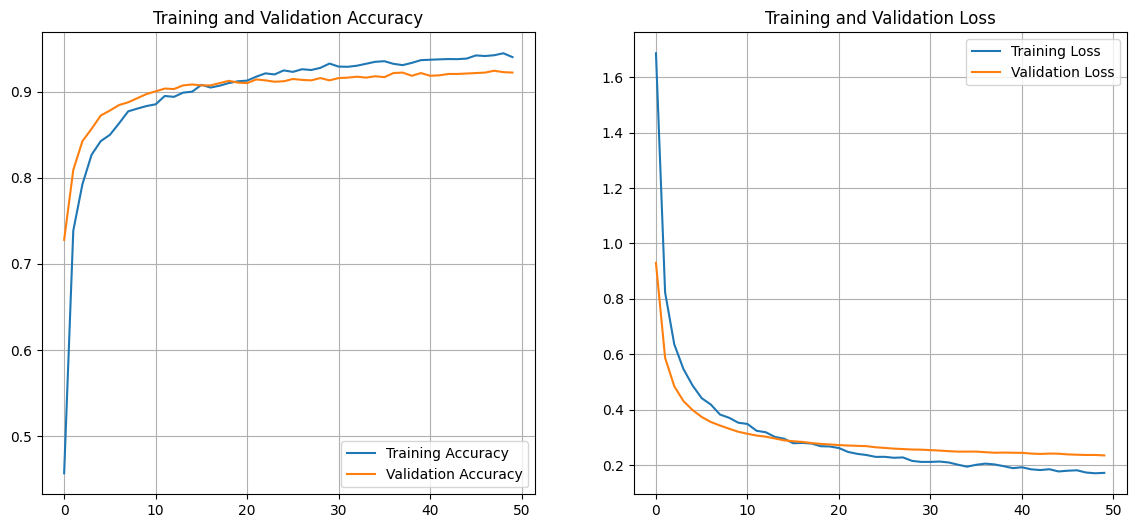

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True) 

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

plot_history(history)

Menggunakan kelas:
0: battery
1: cardboard
2: glass
3: metal
4: organic
5: paper
6: plastic
7: textile
8: trash

--- Evaluasi pada Data Test ---
60/60 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9072 - loss: 0.2843
Test Accuracy : 90.72%
Test Loss     : 0.2843

Melakukan prediksi pada data test...
60/60 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step

--- Classification Report ---
              precision    recall  f1-score   support

     battery     0.9724    0.9860    0.9792       143
   cardboard     0.8989    0.8622    0.8802       196
       glass     0.9010    0.8827    0.8918       196
       metal     0.8838    0.8929    0.8883       196
     organic     0.9431    0.9627    0.9528       241
       paper     0.8510    0.9031    0.8762       196
     plastic     0.8723    0.8367    0.8542       196
     textile     0.9741    0.9797    0.9769       345
       trash     0.8216    0.8085    0.8150       188

    accuracy                         0.9072      1897
   macro avg     0.9020    0.9

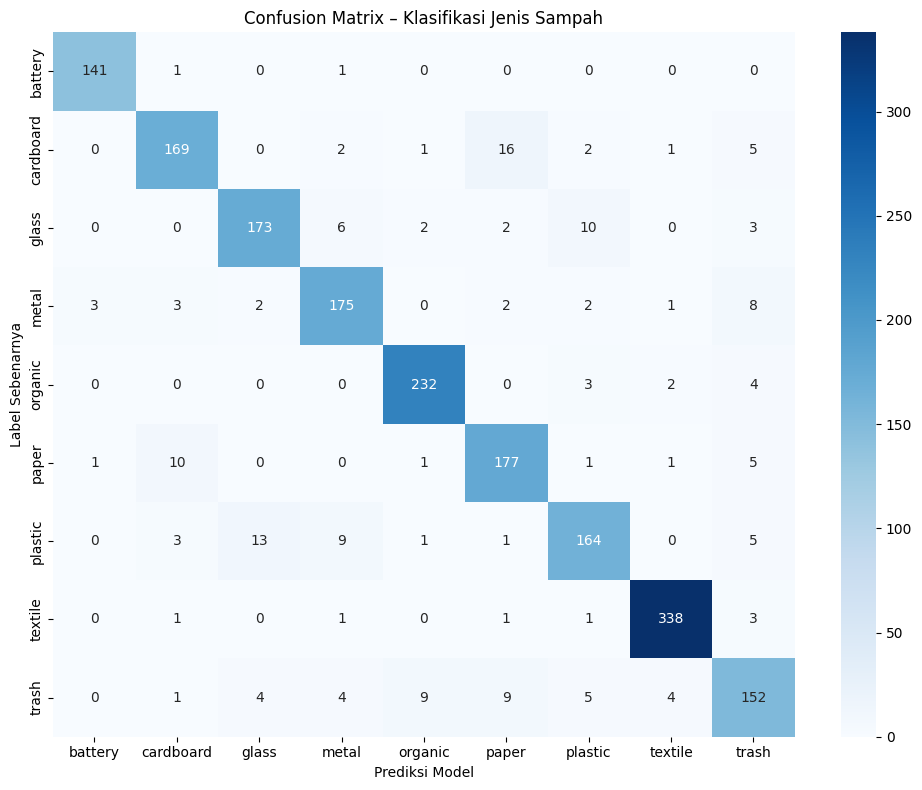

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = [
    'battery', 'cardboard', 'glass', 'metal',
    'organic', 'paper', 'plastic', 'textile', 'trash'
]

print("Menggunakan kelas:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

print("\n--- Evaluasi pada Data Test ---")
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy : {test_acc * 100:.2f}%")
print(f"Test Loss     : {test_loss:.4f}")

print("\nMelakukan prediksi pada data test...")
y_pred_probs = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []

for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)

print("\n--- Classification Report ---")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Prediksi Model")
plt.ylabel("Label Sebenarnya")
plt.title("Confusion Matrix – Klasifikasi Jenis Sampah")
plt.tight_layout()
plt.show()


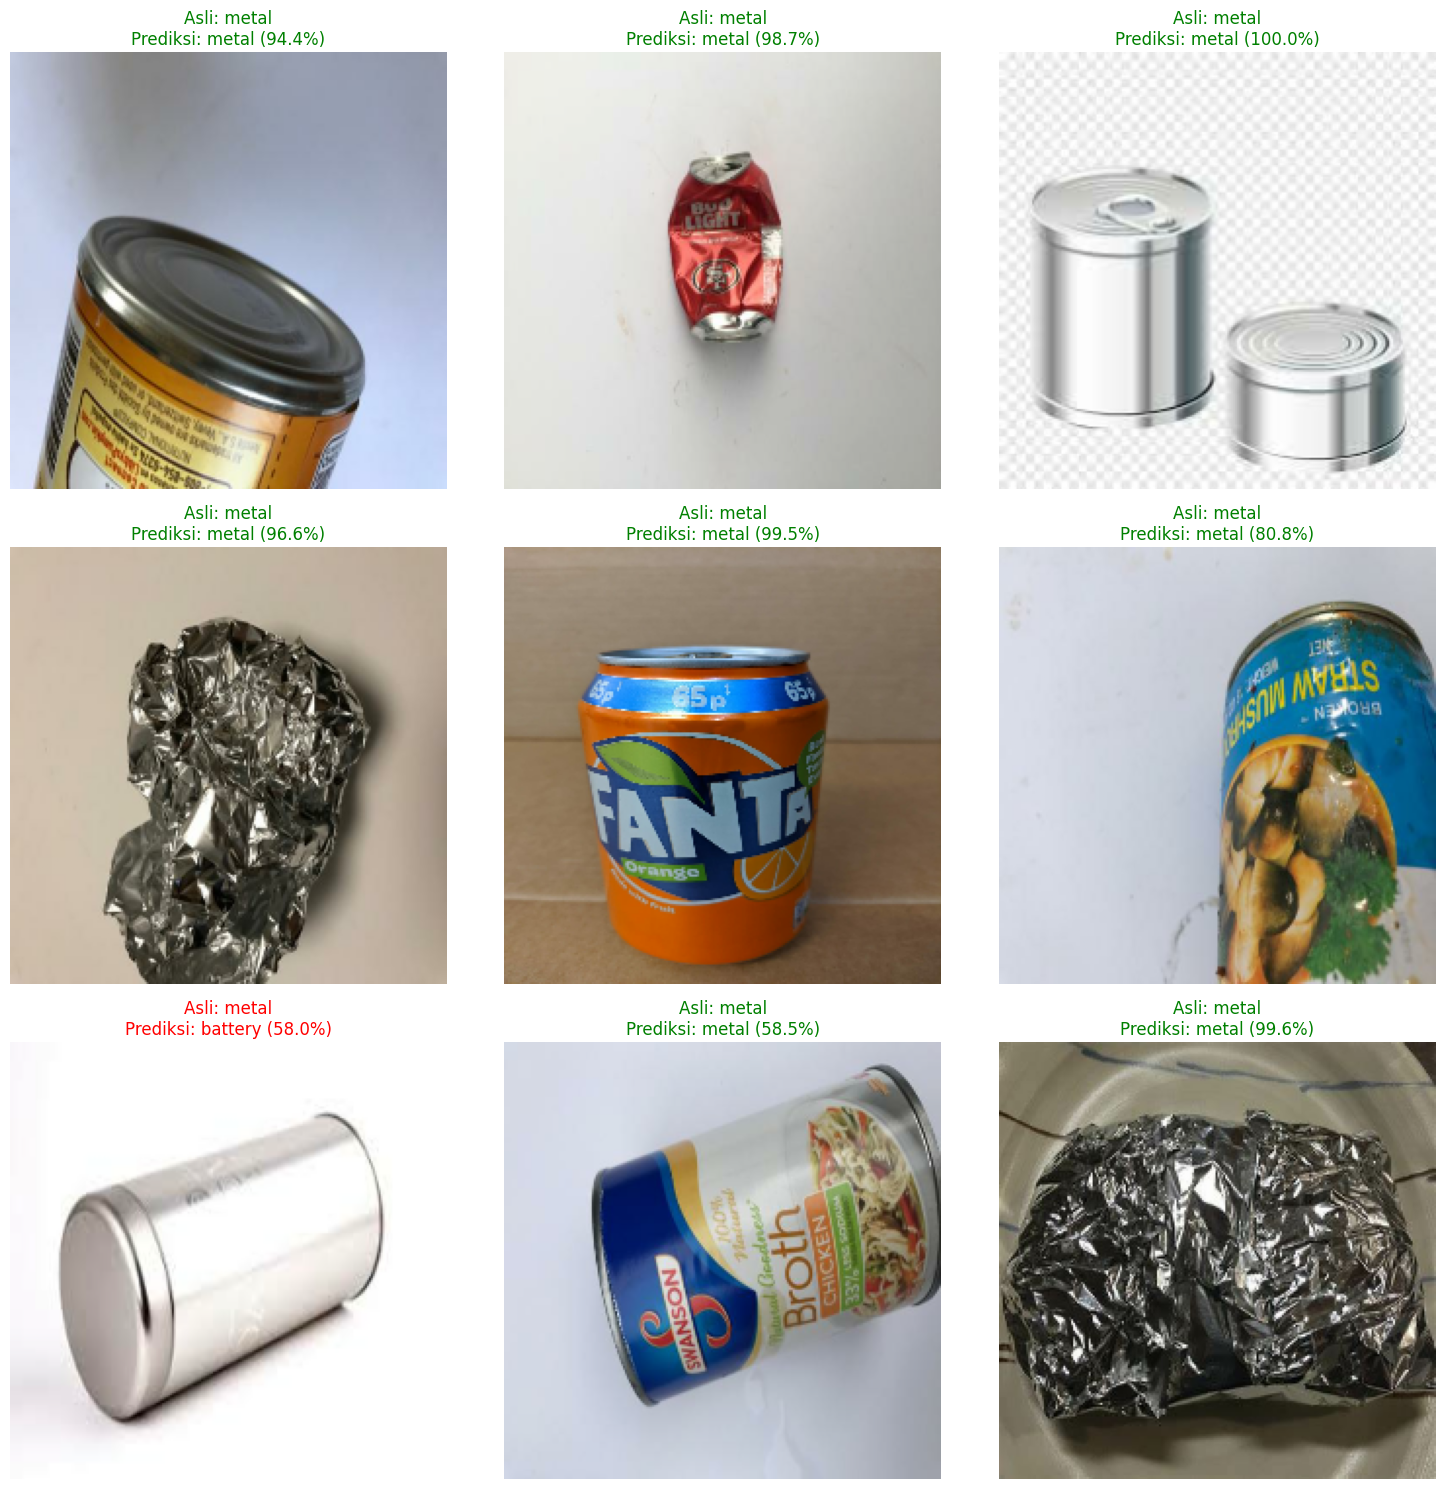

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_prediction_samples(dataset, model, class_names):
    plt.figure(figsize=(15, 15))
    
    shuffled_ds = dataset.shuffle(buffer_size=1000)
    
    for images, labels in shuffled_ds.take(1):
        
        preds = model.predict(images, verbose=0)
        pred_labels = np.argmax(preds, axis=1)
        
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            
            img = images[i].numpy()
            img = (img - img.min()) / (img.max() - img.min())
            plt.imshow(img)
            
            true_label_idx = np.argmax(labels[i].numpy())
            pred_label_idx = pred_labels[i]
            
            true_txt = class_names[true_label_idx]
            pred_txt = class_names[pred_label_idx]
            
            confidence = 100 * np.max(preds[i])
            color = "green" if true_label_idx == pred_label_idx else "red"
            
            plt.title(
                f"Asli: {true_txt}\nPrediksi: {pred_txt} ({confidence:.1f}%)",
                color=color
            )
            plt.axis("off")
            
    plt.tight_layout()
    plt.show()

plot_random_prediction_samples(test_ds, model, class_names)


In [ ]:
for images, labels in test_ds.take(1):
    preds = model.predict(images, verbose=0)

    for i in range(5):
        true_idx = np.argmax(labels[i].numpy())
        pred_idx = np.argmax(preds[i])

        print("TRUE :", class_names[true_idx])
        print("PRED :", class_names[pred_idx])
        print("CONF :", np.max(preds[i]) * 100)
        print("-" * 30)


TRUE : cardboard
PRED : cardboard
CONF : 96.98489904403687
------------------------------
TRUE : cardboard
PRED : cardboard
CONF : 67.83538460731506
------------------------------
TRUE : cardboard
PRED : cardboard
CONF : 99.99314546585083
------------------------------
TRUE : cardboard
PRED : cardboard
CONF : 99.88285899162292
------------------------------
TRUE : cardboard
PRED : cardboard
CONF : 99.01354908943176
------------------------------
